# Exploratory Data Analysis - Bot Detection Competition

This notebook performs initial exploratory data analysis (EDA) on the bot detection competition dataset to understand the characteristics of human vs. AI-generated essays.

## Context and Purpose

The training data for this competition **intentionally contains severe class imbalance** with only 3 AI-generated essay samples versus 1,375 human-written essays.

**Key Competition Strategy:**
- We are provided with `instructions` and `source_text` columns in `train_prompts.csv`
- We are encouraged to generate additional AI essay samples using various language models
- The goal is to achieve parity with human essays in terms of count and model diversity
- This EDA notebook establishes a **baseline analysis** that can be repeated after generating additional AI samples

**Why This EDA is Valuable:**
1. **Baseline Understanding**: Documents patterns in the limited AI samples we have
2. **Feature Discovery**: Identifies potential discriminative features before data augmentation
3. **Reusability**: Same analysis can be run on expanded dataset after AI sample generation
4. **Hypothesis Formation**: Guides our approach to generating realistic AI essays

## Objectives
1. Load and examine the structure of the training data
2. Analyze text length distributions  
3. Examine word count statistics
4. Investigate punctuation usage patterns
5. **Assess severe class imbalance** (human vs. AI)
6. Generate initial hypotheses for feature engineering
7. **Establish baseline metrics** for comparison after data augmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import string
from collections import Counter
import textstat
from wordcloud import WordCloud

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Examination

In [2]:
# Load the training data
train_essays = pd.read_csv('../data/train_essays.csv')
train_prompts = pd.read_csv('../data/train_prompts.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

print("Dataset shapes:")
print(f"Training essays: {train_essays.shape}")
print(f"Training prompts: {train_prompts.shape}")
print(f"Sample submission: {sample_submission.shape}")

Dataset shapes:
Training essays: (1378, 4)
Training prompts: (2, 4)
Sample submission: (3, 2)


In [3]:
# Examine the structure of training essays
print("Training Essays Info:")
print(train_essays.info())
print("\nFirst few rows:")
display(train_essays.head())

Training Essays Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None

First few rows:


,id,prompt_id,text,generated
0,0059830c,0,"Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and b...",0
1,005db917,0,"Transportation is a large necessity in most countries worldwide. With no doubt, cars, buses, and...",0
2,008f63e3,0,"""America's love affair with it's vehicles seems to be cooling"" says Elisabeth rosenthal. To unde...",0
3,00940276,0,How often do you ride in a car? Do you drive a one or any other motor vehicle to work? The store...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps one of the worlds greatest advancements and technol...,0


In [4]:
# Examine training prompts
print("Training Prompts Info:")
print(train_prompts.info())
print("\nPrompt details:")
display(train_prompts[['prompt_id', 'prompt_name']].head())

Training Prompts Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 196.0+ bytes
None

Prompt details:


,prompt_id,prompt_name
0,0,Car-free cities
1,1,Does the electoral college work?


In [5]:
# Check for missing values
print("Missing values in training essays:")
print(train_essays.isnull().sum())
print("\nMissing values in training prompts:")
print(train_prompts.isnull().sum())

Missing values in training essays:
id           0
prompt_id    0
text         0
generated    0
dtype: int64

Missing values in training prompts:
prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


## 2. Class Balance Analysis

Class Distribution:
Human-written (0): 1375 (99.78%)
AI-generated (1): 3 (0.22%)


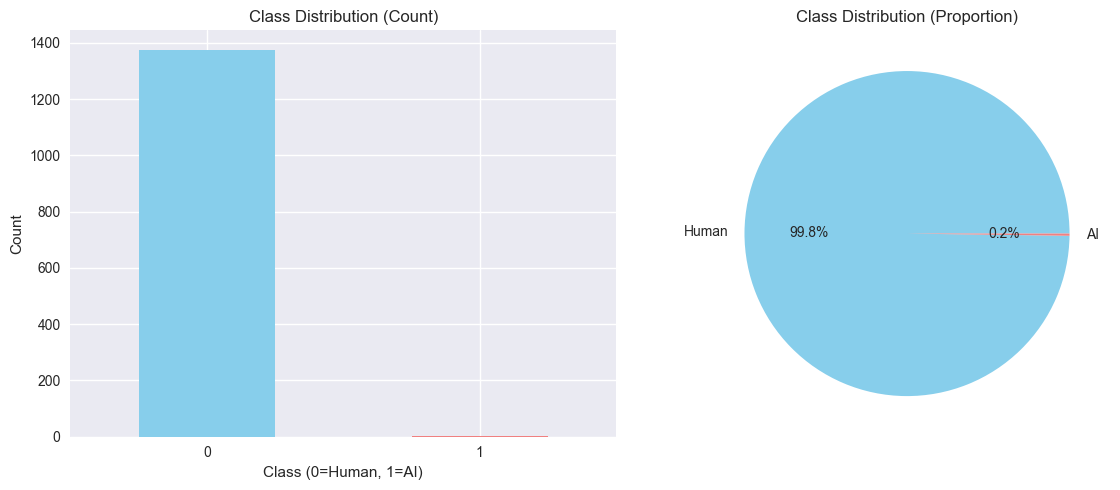

In [6]:
# Analyze class distribution
class_counts = train_essays['generated'].value_counts()
class_proportions = train_essays['generated'].value_counts(normalize=True)

print("Class Distribution:")
print(f"Human-written (0): {class_counts[0]} ({class_proportions[0]:.2%})")
print(f"AI-generated (1): {class_counts[1]} ({class_proportions[1]:.2%})")

# Visualize class balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Class Distribution (Count)')
ax1.set_xlabel('Class (0=Human, 1=AI)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(class_counts.values, labels=['Human', 'AI'], autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral'])
ax2.set_title('Class Distribution (Proportion)')

plt.tight_layout()
plt.show()

## 3. Text Length Analysis

In [7]:
# Calculate text lengths
train_essays['text_length'] = train_essays['text'].str.len()
train_essays['word_count'] = train_essays['text'].str.split().str.len()
train_essays['sentence_count'] = train_essays['text'].str.split('.').str.len() - 1

# Basic statistics for text length by class
text_stats = train_essays.groupby('generated')['text_length'].describe()
print("Text Length Statistics by Class:")
print(text_stats)

Text Length Statistics by Class:
            count         mean         std     min     25%     50%     75%  \
generated                                                                    
0          1375.0  3172.581091  918.439217  1486.0  2556.5  2987.0  3624.5   
1             3.0  1551.000000  224.879968  1356.0  1428.0  1500.0  1648.5   

              max  
generated          
0          8436.0  
1          1797.0  


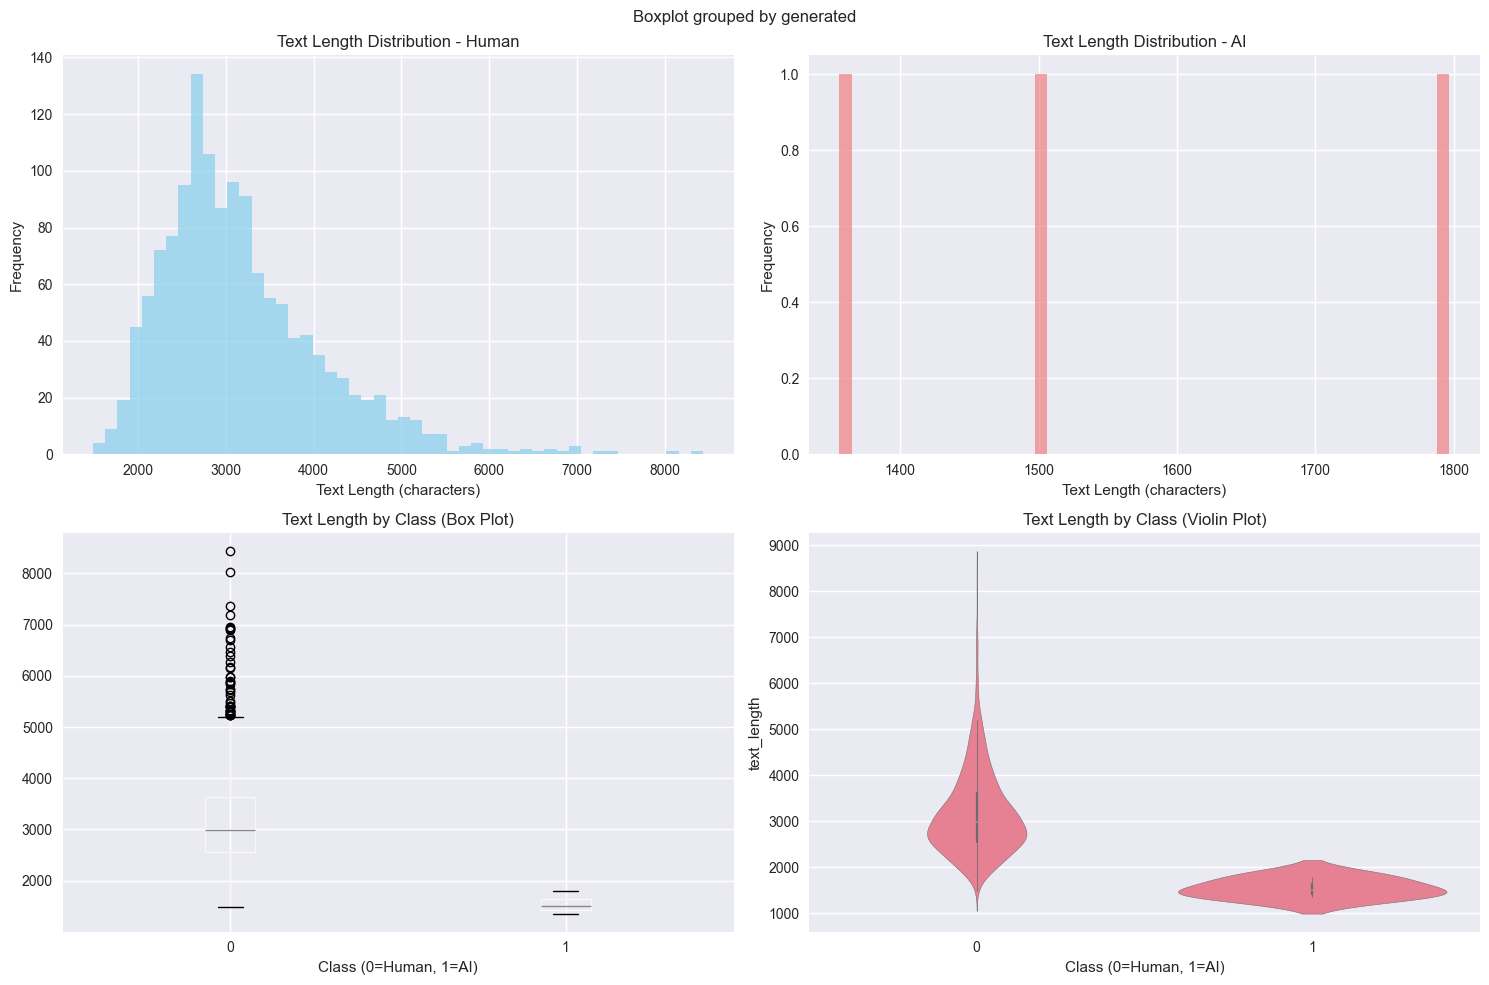

In [8]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution by class
for i, class_val in enumerate([0, 1]):
    class_name = 'Human' if class_val == 0 else 'AI'
    data = train_essays[train_essays['generated'] == class_val]['text_length']
    
    axes[0, i].hist(data, bins=50, alpha=0.7, color='skyblue' if class_val == 0 else 'lightcoral')
    axes[0, i].set_title(f'Text Length Distribution - {class_name}')
    axes[0, i].set_xlabel('Text Length (characters)')
    axes[0, i].set_ylabel('Frequency')

# Box plot comparison
train_essays.boxplot(column='text_length', by='generated', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Class (Box Plot)')
axes[1, 0].set_xlabel('Class (0=Human, 1=AI)')

# Violin plot
sns.violinplot(data=train_essays, x='generated', y='text_length', ax=axes[1, 1])
axes[1, 1].set_title('Text Length by Class (Violin Plot)')
axes[1, 1].set_xlabel('Class (0=Human, 1=AI)')

plt.tight_layout()
plt.show()

## 4. Word Count Analysis

Word Count Statistics by Class:
            count        mean         std    min    25%    50%    75%     max
generated                                                                    
0          1375.0  556.768727  159.493454  268.0  447.5  525.0  639.0  1360.0
1             3.0  260.666667   27.098585  235.0  246.5  258.0  273.5   289.0


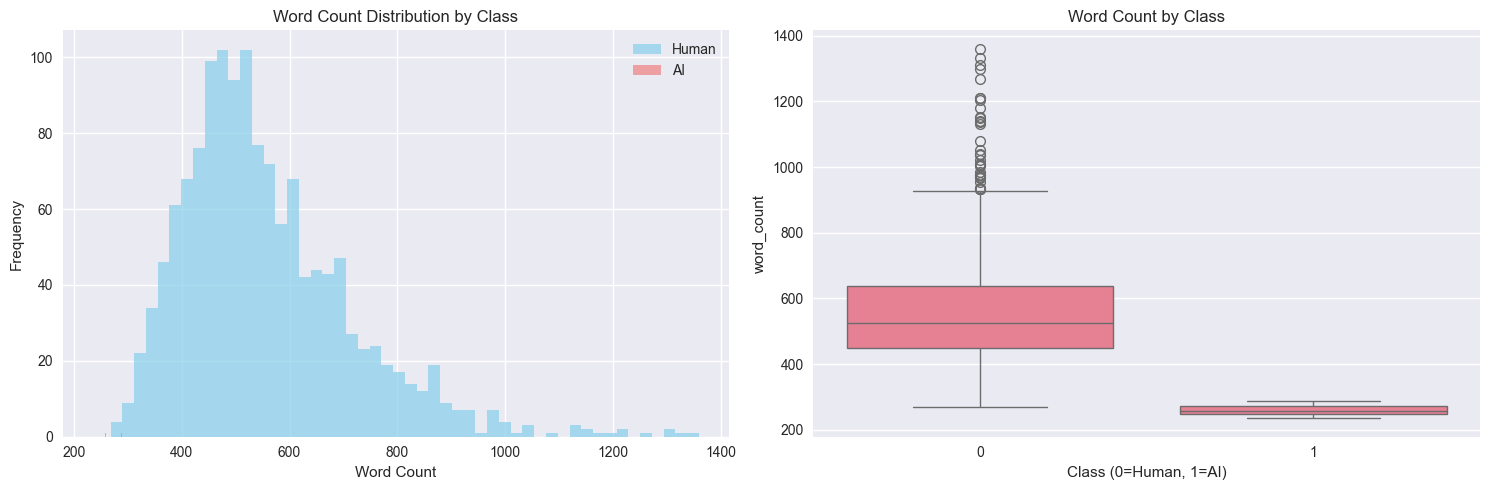

In [9]:
# Word count statistics by class
word_stats = train_essays.groupby('generated')['word_count'].describe()
print("Word Count Statistics by Class:")
print(word_stats)

# Visualize word count distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
train_essays[train_essays['generated'] == 0]['word_count'].hist(bins=50, alpha=0.7, 
                                                                 label='Human', color='skyblue', ax=axes[0])
train_essays[train_essays['generated'] == 1]['word_count'].hist(bins=50, alpha=0.7, 
                                                                 label='AI', color='lightcoral', ax=axes[0])
axes[0].set_title('Word Count Distribution by Class')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
sns.boxplot(data=train_essays, x='generated', y='word_count', ax=axes[1])
axes[1].set_title('Word Count by Class')
axes[1].set_xlabel('Class (0=Human, 1=AI)')

plt.tight_layout()
plt.show()

## 5. Punctuation Usage Analysis

In [10]:
def analyze_punctuation(text):
    """Analyze punctuation usage in text"""
    punctuation_counts = {}
    
    # Count specific punctuation marks
    punctuation_counts['periods'] = text.count('.')
    punctuation_counts['commas'] = text.count(',')
    punctuation_counts['exclamations'] = text.count('!')
    punctuation_counts['questions'] = text.count('?')
    punctuation_counts['semicolons'] = text.count(';')
    punctuation_counts['colons'] = text.count(':')
    punctuation_counts['quotations'] = text.count('"') + text.count("'")
    punctuation_counts['parentheses'] = text.count('(') + text.count(')')
    
    # Total punctuation
    total_punct = sum(1 for char in text if char in string.punctuation)
    punctuation_counts['total_punctuation'] = total_punct
    
    # Punctuation density (per 100 characters)
    text_len = len(text)
    punctuation_counts['punct_density'] = (total_punct / text_len * 100) if text_len > 0 else 0
    
    return punctuation_counts

# Apply punctuation analysis
punct_data = train_essays['text'].apply(analyze_punctuation)
punct_df = pd.DataFrame(list(punct_data))
punct_df['generated'] = train_essays['generated'].values

# Display punctuation statistics by class
print("Punctuation Statistics by Class:")
punct_stats = punct_df.groupby('generated')[['periods', 'commas', 'exclamations', 'questions', 
                                           'punct_density']].mean()
print(punct_stats)

Punctuation Statistics by Class:
             periods     commas  exclamations  questions  punct_density
generated                                                              
0          29.063273  24.064727      0.358545      1.056       2.142308
1          12.000000   9.333333      0.333333      0.000       1.488711


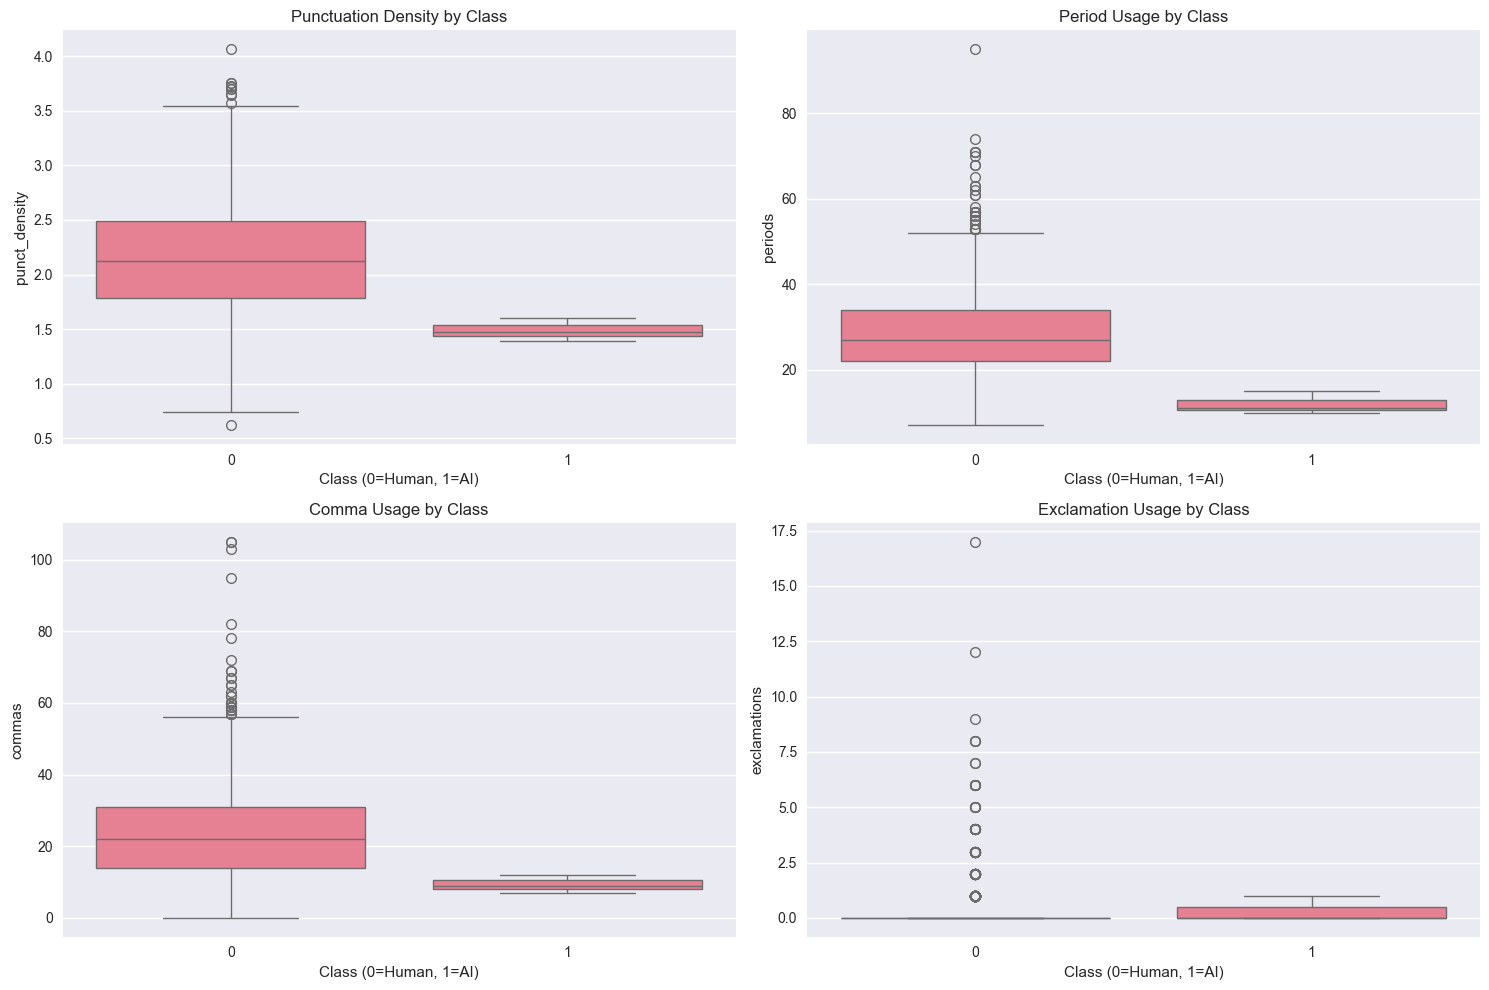

In [11]:
# Visualize punctuation usage
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Punctuation density
sns.boxplot(data=punct_df, x='generated', y='punct_density', ax=axes[0, 0])
axes[0, 0].set_title('Punctuation Density by Class')
axes[0, 0].set_xlabel('Class (0=Human, 1=AI)')

# Period usage
sns.boxplot(data=punct_df, x='generated', y='periods', ax=axes[0, 1])
axes[0, 1].set_title('Period Usage by Class')
axes[0, 1].set_xlabel('Class (0=Human, 1=AI)')

# Comma usage
sns.boxplot(data=punct_df, x='generated', y='commas', ax=axes[1, 0])
axes[1, 0].set_title('Comma Usage by Class')
axes[1, 0].set_xlabel('Class (0=Human, 1=AI)')

# Exclamation usage
sns.boxplot(data=punct_df, x='generated', y='exclamations', ax=axes[1, 1])
axes[1, 1].set_title('Exclamation Usage by Class')
axes[1, 1].set_xlabel('Class (0=Human, 1=AI)')

plt.tight_layout()
plt.show()

## 6. Readability Analysis

In [12]:
def calculate_readability_scores(text):
    """Calculate various readability scores for text"""
    try:
        scores = {
            'flesch_kincaid': textstat.flesch_kincaid_grade(text),
            'flesch_reading_ease': textstat.flesch_reading_ease(text),
            'gunning_fog': textstat.gunning_fog(text),
            'coleman_liau': textstat.coleman_liau_index(text),
            'automated_readability': textstat.automated_readability_index(text),
            'avg_sentence_length': textstat.avg_sentence_length(text),
            'syllable_count': textstat.syllable_count(text),
        }
    except:
        # Handle cases where text might be empty or cause errors
        scores = {key: 0 for key in ['flesch_kincaid', 'flesch_reading_ease', 'gunning_fog', 
                                   'coleman_liau', 'automated_readability', 'avg_sentence_length', 
                                   'syllable_count']}
    return scores

# Calculate readability scores (sample first 1000 rows for faster computation)
sample_size = min(1000, len(train_essays))
sample_essays = train_essays.head(sample_size).copy()

print(f"Calculating readability scores for {sample_size} essays...")
readability_data = sample_essays['text'].apply(calculate_readability_scores)
readability_df = pd.DataFrame(list(readability_data))
readability_df['generated'] = sample_essays['generated'].values

# Display readability statistics
print("\nReadability Statistics by Class:")
readability_stats = readability_df.groupby('generated')[['flesch_kincaid', 'flesch_reading_ease', 
                                                        'gunning_fog', 'avg_sentence_length']].mean()
print(readability_stats)

Calculating readability scores for 1000 essays...


/var/folders/_f/_mxr3yps0dn2fp263fqj4yy00000gn/T/ipykernel_89606/1362817816.py:10: DeprecationWarning: The 'avg_sentence_length' method has been deprecated due to being the same as 'words_per_sentence'. This method will be removed in thefuture.
  'avg_sentence_length': textstat.avg_sentence_length(text),



Readability Statistics by Class:
           flesch_kincaid  flesch_reading_ease  gunning_fog  \
generated                                                     
0               10.203638            57.904425    12.782344   
1               11.641856            51.509308    15.500664   

           avg_sentence_length  
generated                       
0                    20.210354  
1                    22.409091  


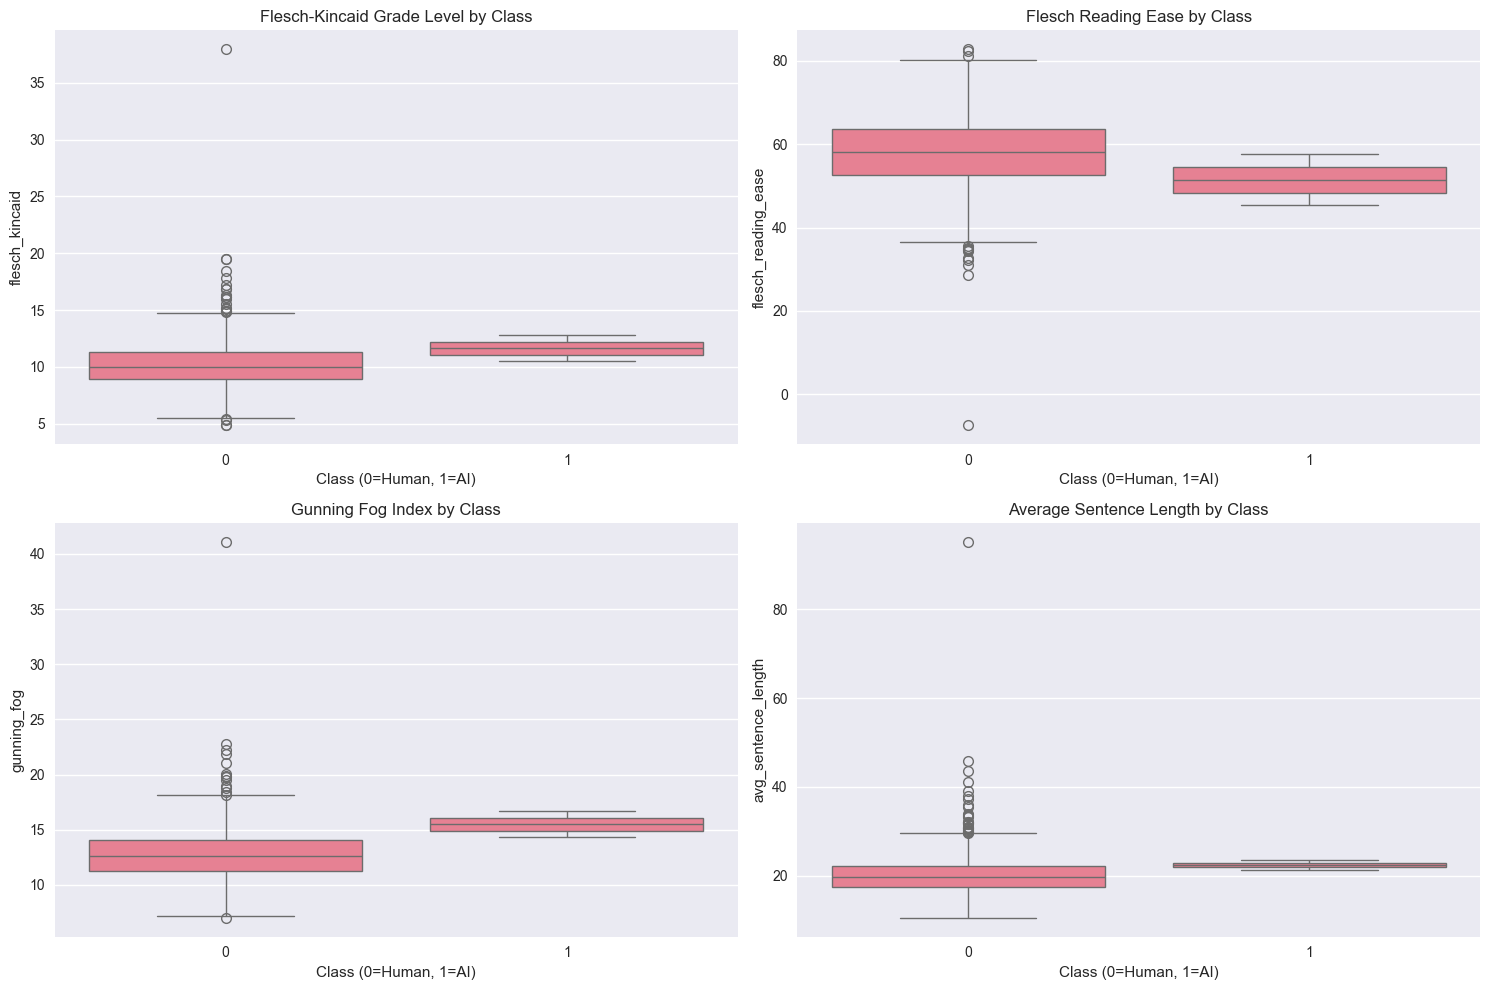

In [13]:
# Visualize readability scores
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flesch-Kincaid Grade Level
sns.boxplot(data=readability_df, x='generated', y='flesch_kincaid', ax=axes[0, 0])
axes[0, 0].set_title('Flesch-Kincaid Grade Level by Class')
axes[0, 0].set_xlabel('Class (0=Human, 1=AI)')

# Flesch Reading Ease
sns.boxplot(data=readability_df, x='generated', y='flesch_reading_ease', ax=axes[0, 1])
axes[0, 1].set_title('Flesch Reading Ease by Class')
axes[0, 1].set_xlabel('Class (0=Human, 1=AI)')

# Gunning Fog Index
sns.boxplot(data=readability_df, x='generated', y='gunning_fog', ax=axes[1, 0])
axes[1, 0].set_title('Gunning Fog Index by Class')
axes[1, 0].set_xlabel('Class (0=Human, 1=AI)')

# Average Sentence Length
sns.boxplot(data=readability_df, x='generated', y='avg_sentence_length', ax=axes[1, 1])
axes[1, 1].set_title('Average Sentence Length by Class')
axes[1, 1].set_xlabel('Class (0=Human, 1=AI)')

plt.tight_layout()
plt.show()

## 7. Prompt Analysis

Essays per Prompt and Class:
generated    0  1  total  ai_percentage
prompt_id                              
0          707  1    708           0.14
1          668  2    670           0.30


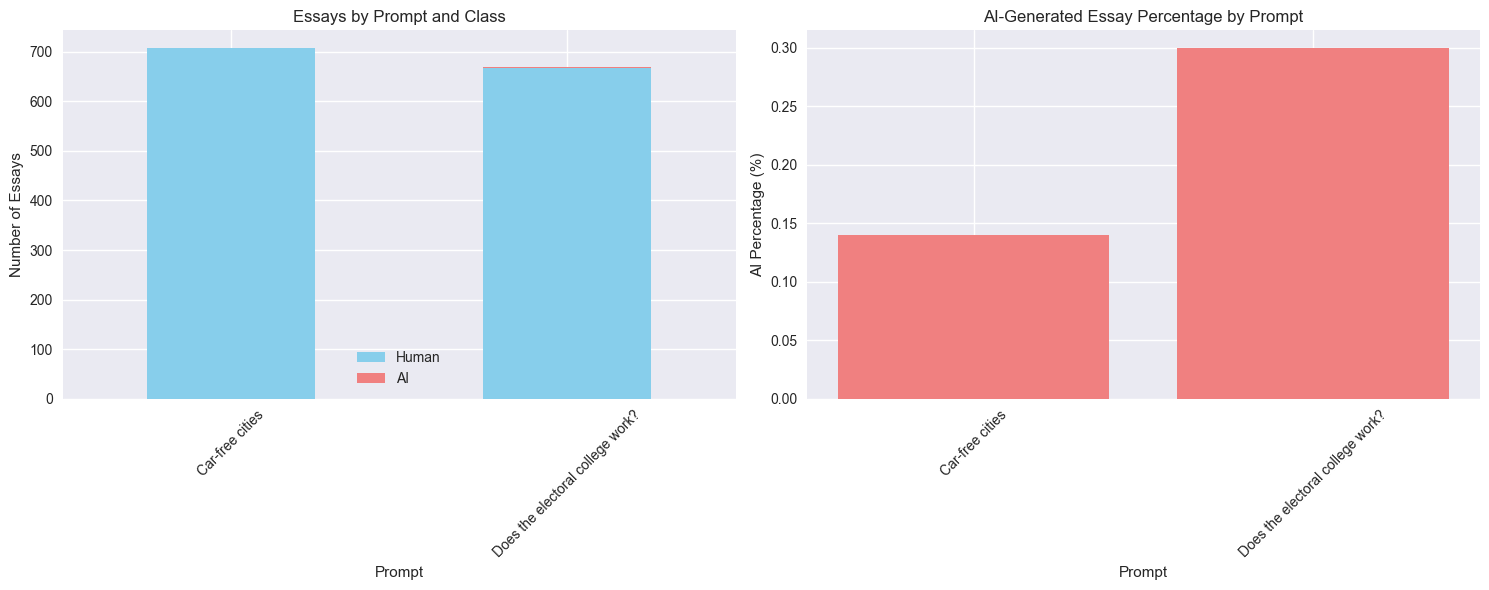

In [14]:
# Analyze distribution across prompts
prompt_analysis = train_essays.groupby(['prompt_id', 'generated']).size().unstack(fill_value=0)
prompt_analysis['total'] = prompt_analysis.sum(axis=1)
prompt_analysis['ai_percentage'] = (prompt_analysis[1] / prompt_analysis['total'] * 100).round(2)

print("Essays per Prompt and Class:")
print(prompt_analysis)

# Merge with prompt names for better visualization
prompt_info = train_prompts[['prompt_id', 'prompt_name']]
prompt_analysis_named = prompt_analysis.reset_index().merge(prompt_info, on='prompt_id')

# Visualize prompt distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
prompt_analysis_named.set_index('prompt_name')[[0, 1]].plot(kind='bar', stacked=True, 
                                                           ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Essays by Prompt and Class')
axes[0].set_xlabel('Prompt')
axes[0].set_ylabel('Number of Essays')
axes[0].legend(['Human', 'AI'])
axes[0].tick_params(axis='x', rotation=45)

# AI percentage by prompt
axes[1].bar(prompt_analysis_named['prompt_name'], prompt_analysis_named['ai_percentage'], 
           color='lightcoral')
axes[1].set_title('AI-Generated Essay Percentage by Prompt')
axes[1].set_xlabel('Prompt')
axes[1].set_ylabel('AI Percentage (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Statistical Significance Testing

In [15]:
from scipy import stats

# Perform statistical tests to determine if differences are significant
human_data = train_essays[train_essays['generated'] == 0]
ai_data = train_essays[train_essays['generated'] == 1]

# T-tests for continuous variables
tests = {
    'text_length': stats.ttest_ind(human_data['text_length'], ai_data['text_length']),
    'word_count': stats.ttest_ind(human_data['word_count'], ai_data['word_count']),
}

# Add punctuation tests
human_punct = punct_df[punct_df['generated'] == 0]
ai_punct = punct_df[punct_df['generated'] == 1]

punct_tests = {
    'punct_density': stats.ttest_ind(human_punct['punct_density'], ai_punct['punct_density']),
    'periods': stats.ttest_ind(human_punct['periods'], ai_punct['periods']),
    'commas': stats.ttest_ind(human_punct['commas'], ai_punct['commas']),
}

# Display results
print("Statistical Significance Tests (p < 0.05 indicates significant difference):")
print("\nText Features:")
for feature, (statistic, p_value) in tests.items():
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{feature}: t={statistic:.3f}, p={p_value:.6f} {significance}")

print("\nPunctuation Features:")
for feature, (statistic, p_value) in punct_tests.items():
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{feature}: t={statistic:.3f}, p={p_value:.6f} {significance}")

print("\nLegend: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

Statistical Significance Tests (p < 0.05 indicates significant difference):

Text Features:
text_length: t=3.057, p=0.002280 **
word_count: t=3.214, p=0.001338 **

Punctuation Features:
punct_density: t=2.151, p=0.031667 *
periods: t=3.028, p=0.002505 **
commas: t=1.843, p=0.065565 ns

Legend: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


## 9. Summary Statistics and Correlation Analysis

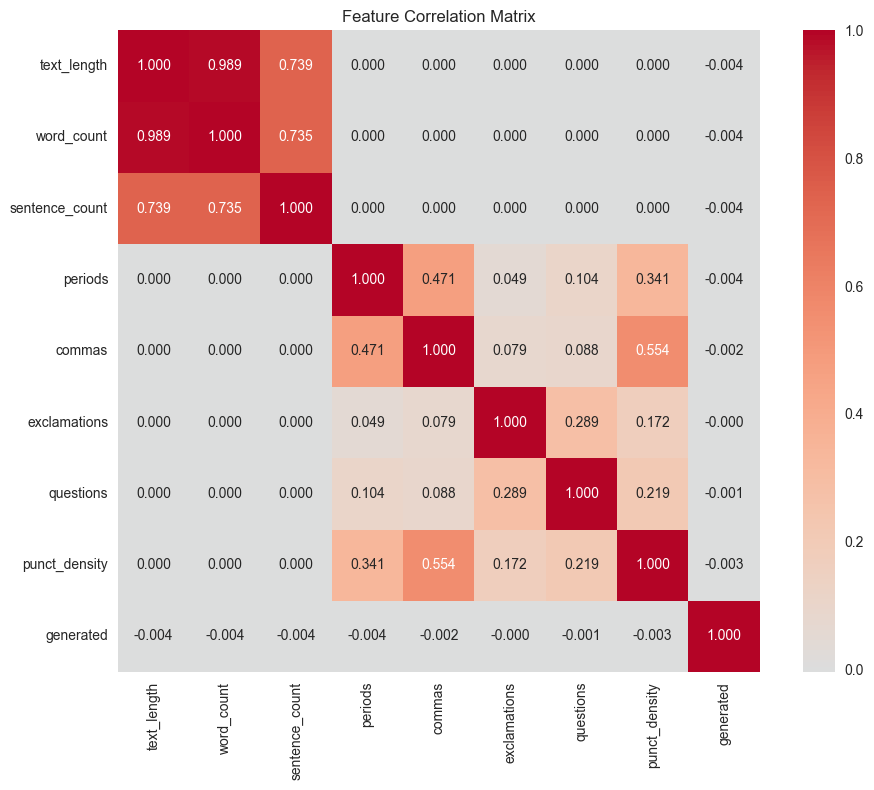


Features ranked by absolute correlation with target (generated):
word_count: 0.0041
text_length: 0.0039
sentence_count: 0.0038
periods: 0.0038
punct_density: 0.0027
commas: 0.0023
questions: 0.0014
exclamations: 0.0000


In [16]:
# Create comprehensive feature dataset
features_df = train_essays[['id', 'prompt_id', 'generated', 'text_length', 'word_count', 'sentence_count']].copy()
features_df = features_df.merge(punct_df[['periods', 'commas', 'exclamations', 'questions', 
                                        'punct_density', 'generated']], on='generated')

# Calculate correlation matrix
feature_cols = ['text_length', 'word_count', 'sentence_count', 'periods', 'commas', 
               'exclamations', 'questions', 'punct_density']
correlation_matrix = features_df[feature_cols + ['generated']].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.3f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_correlations = correlation_matrix['generated'].drop('generated').abs().sort_values(ascending=False)
print("\nFeatures ranked by absolute correlation with target (generated):")
for feature, corr in target_correlations.items():
    print(f"{feature}: {corr:.4f}")

## 10. Key Findings and Initial Hypotheses

In [ ]:
# Summary of key findings
print("=== KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS ===")
print()

print("1. SEVERE CLASS IMBALANCE (INTENTIONAL):")
print(f"   - Human essays: {class_counts[0]} ({class_proportions[0]:.2%})")
print(f"   - AI essays: {class_counts[1]} ({class_proportions[1]:.2%})")
print(f"   - Only 3 AI samples vs 1,375 human samples!")
print(f"   - This is intentional - we need to generate more AI essays")
print()

print("2. TEXT LENGTH PATTERNS (Limited AI Sample):")
human_avg_length = train_essays[train_essays['generated'] == 0]['text_length'].mean()
ai_avg_length = train_essays[train_essays['generated'] == 1]['text_length'].mean()
print(f"   - Human essays average length: {human_avg_length:.0f} characters")
print(f"   - AI essays average length: {ai_avg_length:.0f} characters")
print(f"   - Difference: {abs(human_avg_length - ai_avg_length):.0f} characters")
print(f"   - ⚠️  Based on only 3 AI samples - not statistically reliable")
print()

print("3. WORD COUNT PATTERNS (Limited AI Sample):")
human_avg_words = train_essays[train_essays['generated'] == 0]['word_count'].mean()
ai_avg_words = train_essays[train_essays['generated'] == 1]['word_count'].mean()
print(f"   - Human essays average word count: {human_avg_words:.0f} words")
print(f"   - AI essays average word count: {ai_avg_words:.0f} words")
print(f"   - Difference: {abs(human_avg_words - ai_avg_words):.0f} words")
print(f"   - ⚠️  Based on only 3 AI samples - not statistically reliable")
print()

print("4. PUNCTUATION USAGE (Limited AI Sample):")
human_punct_density = punct_df[punct_df['generated'] == 0]['punct_density'].mean()
ai_punct_density = punct_df[punct_df['generated'] == 1]['punct_density'].mean()
print(f"   - Human essays punctuation density: {human_punct_density:.2f}%")
print(f"   - AI essays punctuation density: {ai_punct_density:.2f}%")
print(f"   - Difference: {abs(human_punct_density - ai_punct_density):.2f}%")
print(f"   - ⚠️  Based on only 3 AI samples - not statistically reliable")
print()

print("5. AVAILABLE PROMPTS FOR AI GENERATION:")
print("   - Prompt 0: Car-free cities")
print("   - Prompt 1: Does the electoral college work?")
print("   - Each prompt has 'instructions' and 'source_text' for AI generation")
print()

print("=== CRITICAL NEXT STEP: AI ESSAY GENERATION ===")
print()
print("**IMMEDIATE PRIORITY**: Generate AI essays to balance the dataset")
print("- Target: ~1,375 AI essays to match human essay count")
print("- Use multiple LLMs: GPT-4, Claude, Gemini, Llama, etc.")
print("- Vary generation parameters: temperature, top_p, etc.")
print("- Use both prompts with provided instructions and source_text")
print("- Document generation metadata (model, parameters, prompt)")
print()
print("**AFTER AI GENERATION**: Re-run this entire EDA notebook")
print("- Compare patterns between different AI models")
print("- Analyze if generated AI essays match human patterns")
print("- Develop robust features that work across model types")
print()

print("=== CURRENT ANALYSIS LIMITATIONS ===")
print()
print("🚨 ALL STATISTICAL FINDINGS ARE PRELIMINARY 🚨")
print("- Only 3 AI samples makes statistical tests unreliable")
print("- Feature correlations may not generalize")  
print("- Model performance estimates would be meaningless")
print("- Pattern analysis is incomplete without sufficient AI data")
print()

print("=== HYPOTHESES FOR POST-GENERATION ANALYSIS ===")
print()
print("1. FEATURE ENGINEERING OPPORTUNITIES:")
print("   - Text length and word count patterns (to be validated)")
print("   - Punctuation usage differences (to be confirmed)")
print("   - Readability scores across multiple AI models")
print("   - N-gram analysis for model-specific patterns")
print("   - Semantic embeddings for content analysis")
print()
print("2. MODELING CONSIDERATIONS:")
print("   - Class balance will be achieved through generation")
print("   - Multi-model detection (different AI sources)")
print("   - Prompt-agnostic features for generalization")
print("   - Cross-validation strategies for model diversity")
print()
print("3. EXPECTED INSIGHTS AFTER AI GENERATION:")
print("   - Model-specific linguistic signatures")
print("   - Temperature/parameter effects on detectability")
print("   - Cross-prompt generalization patterns")
print("   - Ensemble approach effectiveness")

print("\n=== NEXT STEPS PRIORITY ORDER ===")
print("1. 🎯 GENERATE AI ESSAYS using train_prompts.csv")
print("2. 🔄 RE-RUN this EDA notebook on balanced dataset")
print("3. 🛠️  Implement advanced feature engineering pipeline")
print("4. 🤖 Develop and evaluate detection models")
print("5. 📊 Set up experiment tracking with MLflow")
print()
print("📝 Remember: This baseline analysis will be much more valuable")
print("   once we have sufficient AI-generated essays to analyze!")